# Binary Semantic Segmentation: Data preparation

Author: Margaux Masson-Forsythe

## Imports

In [ ]:
!pip3 install hub==2.0.4 && !pip install pillow==4.1.1
# # restart runtime after installing

# %reload_ext autoreload
# %autoreload

In [ ]:
import hub
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
from glob import glob  
import tensorflow as tf
import random
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

## Load data

In [ ]:
!export KAGGLE_USERNAME="xxxx" && export KAGGLE_KEY="xxxxxx" && mkdir -p data && cd data && kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images && unzip -n 38cloud-cloud-segmentation-in-satellite-images.zip

In [ ]:
!ls ./data/38cloud-cloud-segmentation-in-satellite-images

38-Cloud_95-Cloud_Test_Metadata_Files  38-Cloud_training
38-Cloud_Training_Metadata_Files       bibtex.txt
38-Cloud_test                          training_patches_38-cloud_nonempty.csv


In [ ]:
!ls ./data/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training

Entire_scene_gts               train_nir
Natural_False_Color            train_red
train_blue                     training_patches_38-Cloud.csv
train_green                    training_sceneids_38-Cloud.csv
train_gt


In [ ]:
dataset_path = "./data/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training"

In [ ]:
def read_image(path):
    img = np.array(Image.open(path))
    return img 

def read_image_and_imshow(path):
    img = read_image(path)
    plt.imshow(img, cmap='gray')  
    plt.show()

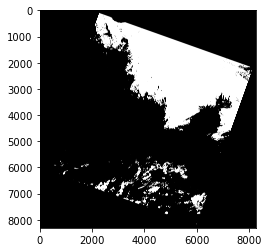

In [ ]:
# Read first image ground truth "Entire Scene"
read_image_and_imshow(glob(dataset_path + "/Entire_scene_gts/*.TIF")[0])

In [ ]:
glob(dataset_path + "/train_gt/*.TIF")[0]

'./data/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_gt/gt_patch_59_3_by_13_LC08_L1TP_044010_20160220_20170224_01_T1.TIF'

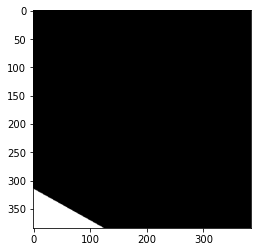

In [ ]:
# Read first image ground truth "Patch" generated from the "Entire Scene"
read_image_and_imshow(glob(dataset_path + "/train_gt/*.TIF")[0])

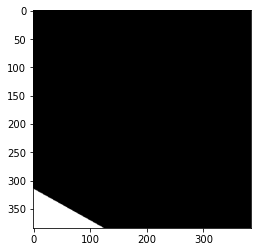

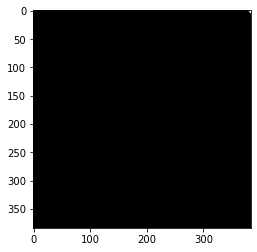

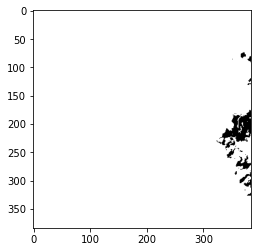

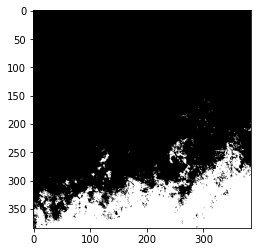

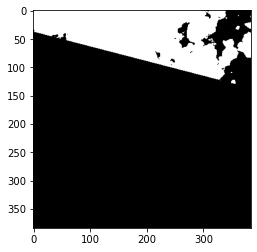

In [ ]:
for i in range(5):
  read_image_and_imshow(glob(dataset_path + "/train_gt/*.TIF")[i])    

We see that some patches are empty. So we can use the csv file training_patches_38-cloud_nonempty.csv to only have non empty images

In [ ]:
# Names of the training patches that are not empty
training_files = pd.read_csv("./data/38cloud-cloud-segmentation-in-satellite-images/training_patches_38-cloud_nonempty.csv")
training_files

,name
0,patch_100_5_by_12_LC08_L1TP_061017_20160720_20...
1,patch_100_5_by_12_LC08_L1TP_063016_20160920_20...
2,patch_100_5_by_12_LC08_L1TP_064014_20160420_20...
3,patch_100_5_by_12_LC08_L1TP_064017_20160420_20...
4,patch_100_5_by_12_LC08_L1TP_066017_20160520_20...
...,...
5150,patch_99_5_by_15_LC08_L1TP_045026_20160720_201...
5151,patch_99_5_by_15_LC08_L1TP_047023_20160920_201...
5152,patch_99_5_by_19_LC08_L1TP_002053_20160520_201...
5153,patch_99_5_by_19_LC08_L1TP_002054_20160520_201...


In [ ]:
list_training_files = list(training_files.name)

patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1
Blue


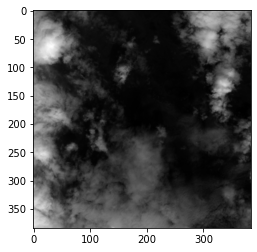

Green


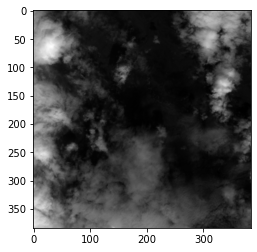

Red


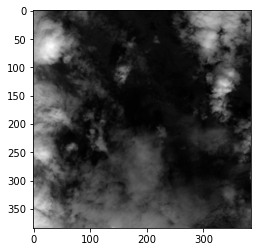

NIR


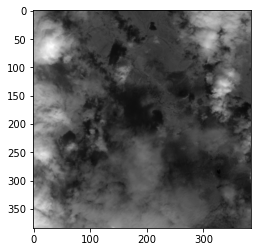

Ground truth


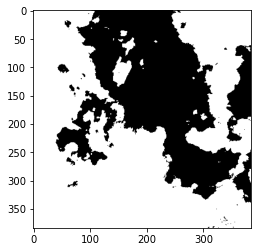

In [ ]:
for image_name in list_training_files:
    print(image_name)
    print("Blue")
    read_image_and_imshow(f"{dataset_path}/train_blue/blue_{image_name}.TIF")  
    print("Green")
    read_image_and_imshow(f"{dataset_path}/train_green/green_{image_name}.TIF")
    print("Red")
    read_image_and_imshow(f"{dataset_path}/train_red/red_{image_name}.TIF")      
    print("NIR")
    read_image_and_imshow(f"{dataset_path}/train_nir/nir_{image_name}.TIF")    
    print("Ground truth")
    read_image_and_imshow(f"{dataset_path}/train_gt/gt_{image_name}.TIF")        
    break

## Combine all bands together and send np arrays to Hub

In [ ]:
def combine_bands(dataset_path, image_path):
    path_red = f"{dataset_path}/train_red/red_{image_name}.TIF"
    path_green = f"{dataset_path}/train_green/green_{image_name}.TIF"
    path_blue = f"{dataset_path}/train_blue/blue_{image_name}.TIF"
    path_nir = f"{dataset_path}/train_nir/nir_{image_name}.TIF"
    path_gt = f"{dataset_path}/train_gt/gt_{image_name}.TIF"
    
    # Read images
    fnames = [path_red, path_green, path_blue, path_nir, path_gt]
    images = [read_image(fname) for fname in fnames]
    
    # Expand dimensions
    expanded_images = [np.expand_dims(img, axis=2) for img in images]
    
    # Combine red, blue, green and nir
    # concat
    img_combined = np.concatenate(expanded_images[:4], axis=2)
    gt = expanded_images[-1]
    
    return (img_combined, gt)

In [ ]:
img_combine_test, gt = combine_bands(dataset_path, list_training_files[0]) 

In [ ]:
img_combine_test.shape

(384, 384, 4)

In [ ]:
gt.shape

(384, 384, 1)

In [ ]:
assert img_combine_test.shape == (384, 384, 4) # should create an images with 4 bands and same size (384, 384)
assert gt.shape == (384, 384, 1) # Ground truth image

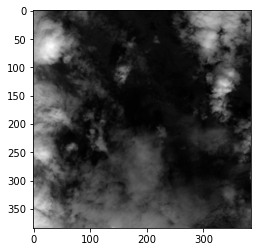

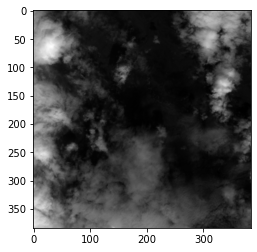

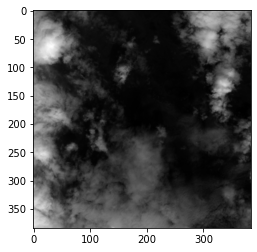

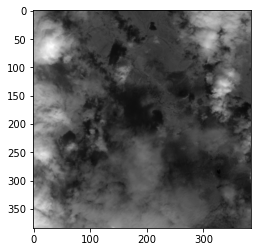

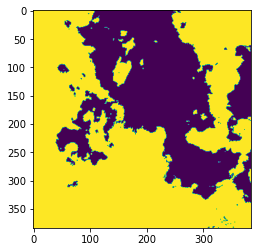

In [ ]:
# # Check we have red, green, blue, nir
for i in range(img_combine_test.shape[2]):
    plt.imshow(img_combine_test[:,:,i], cmap="gray")
    plt.show()
    plt.imshow(gt[:,:,0])

In [ ]:
list_all_combined_images = []
list_all_masks = []

# Loop through all the image paths in the taining csv file
for image_name in tqdm(list_training_files):
    img, mask = combine_bands(dataset_path, image_name)
    list_all_combined_images.append(img)
    list_all_masks.append(mask)


100%|██████████| 5155/5155 [01:13<00:00, 69.80it/s]


In [ ]:
list_all_combined_images_np = np.array(list_all_combined_images)
print(list_all_combined_images_np.shape)
list_all_masks_np = np.array(list_all_masks)
print(list_all_masks_np.shape)

(5155, 384, 384, 4)
(5155, 384, 384, 1)


In [ ]:
assert list_all_combined_images_np[0].shape == (384, 384, 4) # combined image
assert list_all_masks_np[0].shape == (384, 384, 1) # ground truth

## Send data (np arrays) to Hub

In [ ]:
assert list_all_combined_images_np.shape[0] == list_all_masks_np.shape[0] 
list_all_combined_images_np.shape[0]

5155

In [ ]:
!activeloop login -u username -p password

In [ ]:
hub_cloud_path = "hub://margauxmforsythe/38-cloud-segmentation"

In [ ]:
# This will take some time -- Go get a coffee :)
with hub.empty(hub_cloud_path) as ds:
    # Create the tensors 
    ds.create_tensor('images')
    ds.create_tensor('masks')

    # Add arbitrary metadata - Optional
    ds.info.update(description = 'Cloud segmentation dataset')
    ds.images.info.update(camera_type = 'SLR')
    
    # Iterate through the images and their corresponding embeddings, and append them to hub dataset
    for i in tqdm(range(len(list_all_combined_images_np))):
        ds.images.append(list_all_combined_images_np[i])  # Append to Hub Dataset
        ds.masks.append(list_all_masks_np[i]) # Append to Hub Dataset

Your Hub dataset has been successfully created!


100%|██████████| 5155/5155 [3:24:59<00:00,  2.39s/it]   


## Check the Hub dataset 

In [ ]:
# Load the data
print("Load data...")
ds = hub.dataset(hub_cloud_path)

Load data...
hub://margauxmforsythe/38-cloud-segmentation loaded successfully.


In [ ]:
print(ds.images[0].numpy().shape)

(384, 384, 4)


In [ ]:
len(ds)

5155

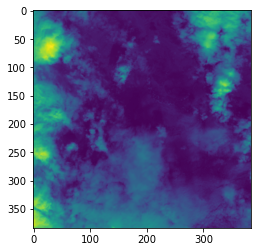

In [ ]:
plt.imshow(ds.images[0].numpy()[:,:,0])

In [ ]:
ds.masks[0].numpy().shape

(384, 384, 1)

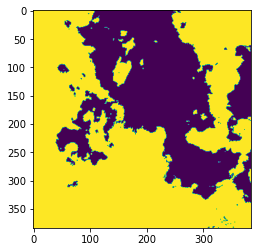

In [ ]:
plt.imshow(ds.masks[0].numpy()[:,:,0])

Training notebook [here](https://colab.research.google.com/drive/1obfH__9TqwSmmX8344yCGoP_ckXwtCul?usp=sharing)